# Proyecto de investigación CIFI BBVA 2023

## Marco Teórico

La teoría moderna de portafolios es un enfoque ampliamente aceptado en el campo de las finanzas que se basa en la idea de que los inversionistas pueden construir carteras de activos que maximicen el rendimiento esperado para un nivel dado de riesgo, o minimicen el riesgo para un nivel dado de rendimiento esperado. Esta teoría fue desarrollada principalmente por Harry Markowitz en la década de 1950 y es un pilar fundamental en la gestión de inversiones.

En términos generales, la teoría moderna de portafolios se centra en la diversificación y el equilibrio entre el rendimiento y el riesgo. Los inversionistas pueden combinar diferentes activos en sus carteras de manera que los movimientos de los precios de los activos individuales se compensen entre sí, reduciendo así el riesgo total de la cartera. Este enfoque se basa en la premisa de que los inversionistas son racionales y buscan maximizar su utilidad, considerando tanto el rendimiento como el riesgo al tomar decisiones de inversión.

En el marco de la teoría moderna de portafolios, se introduce el concepto de la **frontera eficiente**, que representa todas las posibles combinaciones de activos que ofrecen el máximo rendimiento esperado para un nivel dado de riesgo, o el mínimo riesgo para un nivel dado de rendimiento esperado. Los inversionistas pueden elegir cualquier punto en esta frontera eficiente, dependiendo de sus preferencias de riesgo y rendimiento.

#### Deficiencias del modelo de Markowitz

El modelo de Markowitz representa una visión muy simple e intuitiva de la optimización de portafolios, ideal como introducción teórica. Entre los atributos que aporta dicho modelo se encuentra: 
 * La importancia de la diversificación en la gestión de carteras.
 * El concepto de frontera eficiente o combinaciones óptimas de portafolios.
 * Enfoque cuantitativo en la toma de decisiones de inversión.
 
Sin embargo, este modelo presenta deficiencias, tales como: supuestos irrealistas (distribución normal de los rendimientos, o aversión al riesgo constante de los inversionistas), alta sensibilidad ante un cambio en las estimaciones de los parámetros (especialmente rendimiento esperado); todo esto en la práctica se traduce en carteras poco diversificadas y con ponderaciones altamente concentradas en unos pocos activos.

#### Optimización con Black-Litterman

El modelo Black-Litterman se limita al momento de realizar suposiciones, de hecho considera las estimaciones del inversionista como expectativas sobre los activos y le da un tratamientno bayesiano al incorporarlas al modelo; por otra parte, rescata el concepto de eficiencia en los mercados y, lo que tradicionalmente en Markowitz son los retornos esperados, en Black-Litterman son los retornos implícitos de equilibrio de mercado (calculados previo a la optimización). Básicamente es el rendimiento que debe tener cada activo acorde a su capitalización para conformar el rendimiento real del mercado o benchmark que conforma.
Esta metodología trae como resultado una mejora considerable en las estimaciones así como en la ponderación de los activos, construye carteras mucho más diversificadas; aunque su principal atractivo es la personalización en la construcción de carteras pues el hecho de que los inversionistas puedan incorporar de forma directa sus expectativas y opiniones sobre los acctivos a invertir, genera un cambio en las estimaciones y por ende distintas asignaciones de peso entre los activos.

#### ¿Por qué implementar una matriz de covarianzas robustas?

Estimar una matriz de covarianzas tiene ciertos retos, principalmente el capturar los datos que enrealidad aporten a la varibilidad de un activo con respecto a otro, decir, identificar tando el ruido como los valores atípicos, pues la matriz resultante puede verse afectada y por consecuente los resultados de los análisis y modelos que dependen de la matriz. Una varianza robusta es una varianza sometida previamente a un modelo de optimización que busca minimizar el impacto de los valores atípicos. Lo anterior permite construir portafolios que sean menos sensibles a las fluctuaciones extremas.

## Covarianzas robustas

El metodo de Ledoit-Wolf se basa en el enfoque de la maldicion de la alta dimensionalidad. En los portafolio de inversion es necesario calcular un vector de retornos esperados para n activos es decir $\mu \in R^{1xn}$ de tal manera que al aumentar el numero de activos el vector crece linealmente segun la cantidad de activos. Tambien es necesario calcular las volatilidades o las varianzas $v \in R^{1xn}$ nuevamente crece lineal con respecto a los activos. Sin embargo tambien es necesario calcular covarianza las cuales crecen casi exponencialmente. Es decir se calcularan $n$ retornos esperados, $n$ volatilidades y $2n + [n(n-1)/2]$ covarianzas. Esto nos dice que conforme mayor sea el numero se activos la probabilidad de cometer errores de estimacion para las covarianzas aumentara considerablemente. El método de estimación de la covarianza de Ledoit-Wolf emplea la reducción de un estimador estructurado. Esta técnica es particularmente útil cuando se trata de datos de alta dimensión, donde hay más características que muestras disponibles. En estas circunstancias, la matriz de covarianza empírica que se creó utilizando los datos no es una estimación confiable. Para evitar esto, el método de contracción de Ledoit-Wolf fortalece la matriz de covarianza empírica reduciéndola en la dirección de la matriz de identidad.
    
El metodo de machenko pastur utiliza la teoria de las matrices aletorias mas eliminar el ruido aleatorio de las matrices de covarianza. El enfoque se marchenko pastur se basa en calcular la distribucion de densidad de probabilidad los valores propio de una matriz aleatoria, de tal manera que al calcular los valores propios de la matriz de covarianza, todo valor que caiga dentro de la distribucion se considerara como aleatoria y cualquier valor propio mayor al valor propio maximo de la distribucion de marchenko se condierara como señal.

#### Método Machenko Pastur

In [1]:
# Funciones desarrolladas
%run desnoising_functions.ipynb

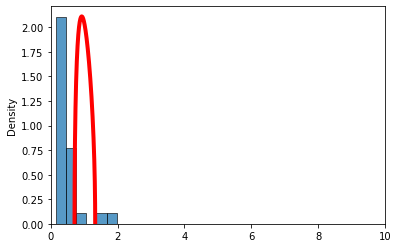

In [2]:
# Preparación de datos
prices = prices = pd.read_csv('historical_prices.csv').set_index('Date')
returns = prices.pct_change().dropna()

# Retornos logarítmicos
log_in_sample = returns.apply(lambda x: np.log(x+1))

# Varainzas y desviación stándar
variances = np.diag(log_in_sample.cov())
std = np.sqrt(variances)

# Parámetros para optimizador Marchenko
T, N = returns.shape
Q = T/N
correlation_matrix = log_in_sample.interpolate().corr()

# Filtración de valores propios
compare_eigenvalue_distribution(correlation_matrix,Q, set_autoscale=False)

Entonces es hora de filtrar la matriz. Veamos los valores propios mayores que el valor propio teórico más grande.

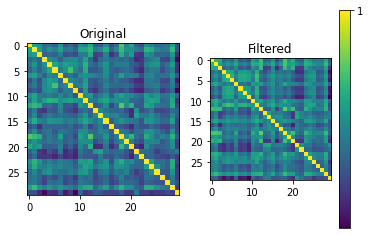

In [3]:
sigma = 1
max_theorical_eval = np.power(sigma*(1+np.sqrt(1/Q)),2)

D,S= np.linalg.eigh(correlation_matrix)

# Filtar valores propios
D[D<= max_theorical_eval] = 0

# Reconstruir la matriz correlación
temp = np.dot(S, np.dot(np.diag(D),S.T))

# Matriz de covarianza filtrada
filtered_cov= np.dot(np.diag(std),
                    np.dot(temp, np.diag(std)))

# Establezca las entradas diagonales en 0
np.fill_diagonal(temp,1)
filtered_matrix = temp


f = plt.figure()
ax = plt.subplot(121)
ax.imshow(correlation_matrix)
plt.title("Original")
ax = plt.subplot(122)
plt.title("Filtered")
a = ax.imshow(filtered_matrix)
cbar = f.colorbar(a, ticks=[-1, 0, 1])

#### Método Ledoit-Wolf

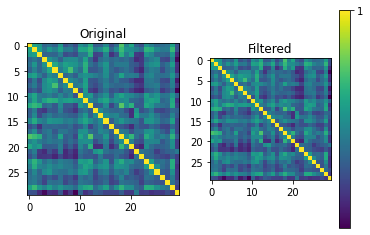

In [4]:
# Importamos paquetes
from pypfopt import risk_models

# Matriz de covarianza optimizada por Ledoit-Wolf
wolf_matrix = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

# Correlación de matriz optimizada
wolf_corr = risk_models.cov_to_corr(wolf_matrix)

f = plt.figure()
ax = plt.subplot(121)
ax.imshow(correlation_matrix)
plt.title("Original")
ax = plt.subplot(122)
plt.title("Filtered")
a = ax.imshow(wolf_corr)
cbar = f.colorbar(a, ticks=[-1, 0, 1])

## Análisis comparativo

In [5]:
# Importamos Librerías
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

Para caso de este proyecto todos los datos fueron obtenidos con la librería `yfinance` y transformados a un archivo `*.csv` y facilitar su implementación.

In [6]:
# Data de precios de acciones
prices = pd.read_csv('historical_prices.csv').set_index('Date')

# Data de Benchmark
market = pd.read_csv('historical_market.csv').set_index('Date')

#### Markowitz

Grafica de frontera eficiente

C:\Users\hecto\anaconda3\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


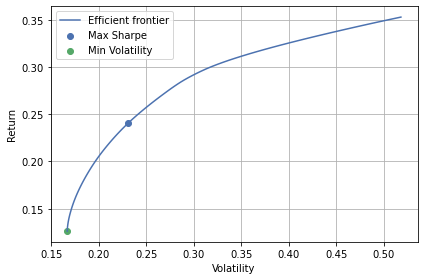

In [7]:
# Obtención de rendimeintos esperados
expected_returns = (prices.pct_change().dropna()).mean() *252

# Matriz de covarianza
covariance_simple = (prices.pct_change().dropna()).cov() *252

# Optimizador
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(expected_returns, covariance_simple)

fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
ef_min_var = ef.deepcopy()

# Ploteo
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

ef_max_sharpe.max_sharpe()
ret_max_sharpe, std_max_sharpe, _ = ef_max_sharpe.portfolio_performance(risk_free_rate=0.05)
ax.scatter(std_max_sharpe, ret_max_sharpe, label="Max Sharpe")

ef_min_var.min_volatility()
ret_min_var, std_min_var, _ = ef_min_var.portfolio_performance(risk_free_rate=0.05)
ax.scatter(std_min_var, ret_min_var, label="Min Volatility")
ax.grid()
ax.legend()
plt.show()

Asignación de peso de activos según el modelo markowitz

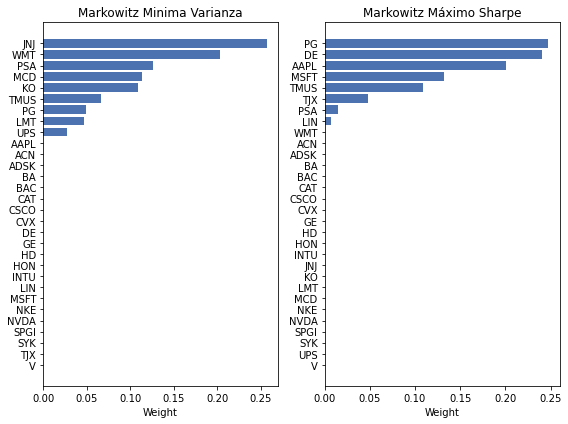

In [62]:
from pypfopt import plotting
from pypfopt.cla import CLA

# Optimizador
markowtiz = CLA(expected_returns, covariance_simple, weight_bounds=(0, 1))

# Ploteo
fig, ax = plt.subplots(1,2, figsize=(8,6))
plotting.plot_weights(markowtiz.min_volatility(), ax=ax[0])
ax[0].set_title('Markowitz Minima Varianza')
plotting.plot_weights(markowtiz.max_sharpe(), ax=ax[1])
ax[1].set_title('Markowitz Máximo Sharpe')

plt.show()

#### Black-Litterman

El modelo Black-Litterman está comprendido por lo siguientes parámetros:

####  $$E(R) = [(\tau\Sigma)^{-1} + P^T \Omega^{-1} P]^{-1} [(\tau\Sigma)^{-1}\Pi + P^T \Omega^{-1} Q]$$
Donde:
* $E(R)$ es un vector$^{(N, 1)}$ de rendimientos esperados donde $N$ es la cantidad de activos.
* $Q$ es un vector$^{(K,1)}$ de expectativas.
* $P$ es la matriz$^{(K,N)}$ de selección, básicamente le indica al modelo qué vista le corresponde a cada activo.
* $\Omega$ es una matriz$^{(K,K)}$ de certidumbre de las expectativas.
* $\Pi$ es un vector$^{(N, 1)}$ de retornos implícitos de mercado (retornos previos).
* $\Sigma$ es la matriz de covarianza de los retornos de los activos.
* $\tau$ es un escalar modificable según a los intervalos de confianza establecidos.

Para calcular $\Pi$:

$$\Pi = \delta\Sigma w_{mkt}$$
Donde: 
* $w_{mkt}$ son los pesos según la capitalización de mercado.
*  $\Sigma$ es la matriz de covarianza de los retornos de los activos.
* $\delta$ es la aversión al riesgo implícita de mercado. Se obtiene: 
$$\delta = \frac{R - R_f}{\sigma^2}$$

In [11]:
# Paquetes a utilizar
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

# Obtención de delta
delta = black_litterman.market_implied_risk_aversion(market).values[0]

In [12]:
# Capitalizaciones de mercado de los activos
mcaps = {'AAPL': 2012183782816.5, 'ACN': 174617374887.64, 'ADSK': 39946002863.18, 'BA': 115242033656.88,
 'BAC': 146114229644.27, 'CAT': 119758217980.78, 'CSCO': 187228709183.75, 'CVX': 328444974351.87,
 'DE': 122131770627.69, 'GE': 70118436372.38, 'HD': 309392488556.62, 'HON': 140995602771.94,
 'INTU': 108292705202.23, 'JNJ': 416026818585.88, 'KO': 268724131813.56, 'LIN': 156485860393.75,
 'LMT': 118349099022.56, 'MCD': 188037608580.72, 'MSFT': 1770325432275.92, 'NKE': 176398113894.86,
 'NVDA': 357654459525.69, 'PG': 348365920034.17, 'PSA': 47725404784.74, 'SPGI': 105320250921.6,
 'SYK': 92137736601.6, 'TJX': 90249040731.24, 'TMUS': 161906500000.0, 'UPS': 144529699877.36,
 'V': 420265007802.79, 'WMT': 377299439163.48}

In [13]:
# Obtención de prior (rendimientos implícitos de equilibrio)
    # Incluímos nuestra matriz robusta
pi = black_litterman.market_implied_prior_returns(mcaps, delta, wolf_matrix)

Para obtener las expectativas, desarrollamos un modelo de regresión por cuantiles:

In [14]:
# Expectativas
viewdict = {
    'AAPL':0.10,
    'MSFT':0.10,
    'GE': 0.07,
    'LMT': 0.05,
    'KO': 0.02
}

# Rango de rendimeintos
intervals = [
    (0, 0.15),
    (0.2, 0.18),
    (-0.02, 0.13),
    (-0.01, 0.08),
    (-0.03, 0.05)
]

# Ontención de Omega
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)
omega = np.diag(variances)

Implementación modelo Black-Litterman

C:\Users\hecto\anaconda3\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


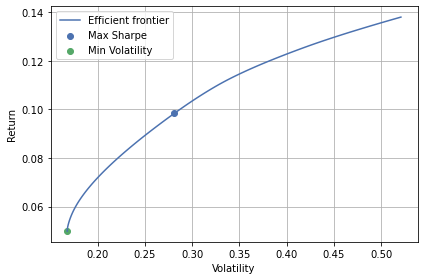

In [15]:
# Modelo Black-Litterman con paquete Pypfopt
bl = BlackLittermanModel(wolf_matrix, pi=pi, market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

# Vector de retornos Black-Litterman
bl_returns = bl.bl_returns()

# Matriz de covarianza Black-Litterman
bl_cov = bl.bl_cov()

from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientFrontier

bl_ef = EfficientFrontier(bl_returns, bl_cov)

fig, ax = plt.subplots()
bl_ef_max_sharpe = bl_ef.deepcopy()
bl_ef_min_var = bl_ef.deepcopy()

# Ploteo
plotting.plot_efficient_frontier(bl_ef, ax=ax, show_assets=False)

bl_ef_max_sharpe.max_sharpe()
bl_ret_max_sharpe, bl_std_max_sharpe, _ = bl_ef_max_sharpe.portfolio_performance(risk_free_rate=0.05)
ax.scatter(bl_std_max_sharpe, bl_ret_max_sharpe, label="Max Sharpe")

bl_ef_min_var.min_volatility()
bl_ret_min_var, bl_std_min_var, _ = bl_ef_min_var.portfolio_performance(risk_free_rate=0.05)
ax.scatter(bl_std_min_var, bl_ret_min_var, label="Min Volatility")
ax.grid()
ax.legend()
plt.show()

Asignación de pesos según Black-Litterman

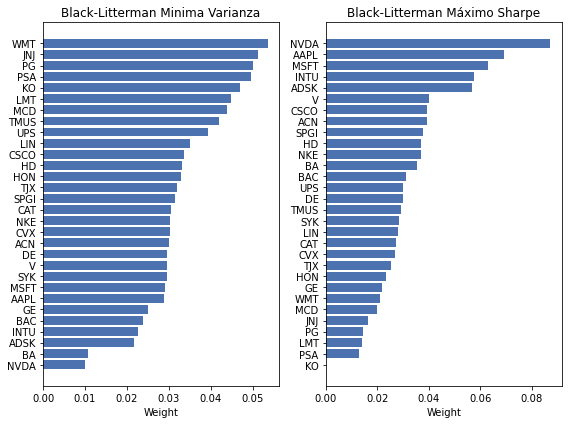

In [64]:
from pypfopt import plotting
from pypfopt.cla import CLA
from pypfopt import objective_functions

# Optimizador
blacklitterman = EfficientFrontier(bl_returns, bl_cov)
blacklitterman.add_objective(objective_functions.L2_reg)

bl_maxsharpe = blacklitterman.deepcopy()
bl_maxsharpe.max_sharpe()
bl_maxsharpe_weights = bl_maxsharpe.clean_weights()

bl_minvariance = blacklitterman.deepcopy()
bl_minvariance.min_volatility()
bl_minvar_weights = bl_minvariance.clean_weights()

# Ploteo
fig, ax = plt.subplots(1,2, figsize=(8,6))
plotting.plot_weights(bl_minvar_weights, ax=ax[0])
ax[0].set_title('Black-Litterman Minima Varianza')
plotting.plot_weights(bl_maxsharpe_weights, ax=ax[1])
ax[1].set_title('Black-Litterman Máximo Sharpe')
plt.show()

#### Backtest

Comparación de expectativas de rendidmiento

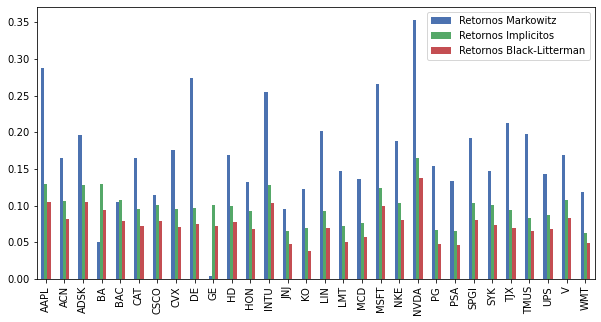

In [34]:
rets_df = pd.DataFrame([expected_returns, pi, bl_returns], 
             index=["Retornos Markowitz", "Retornos Implicitos", "Retornos Black-Litterman"]).T
rets_df.plot.bar(figsize=(10,5));

Desempeño de los portafolios

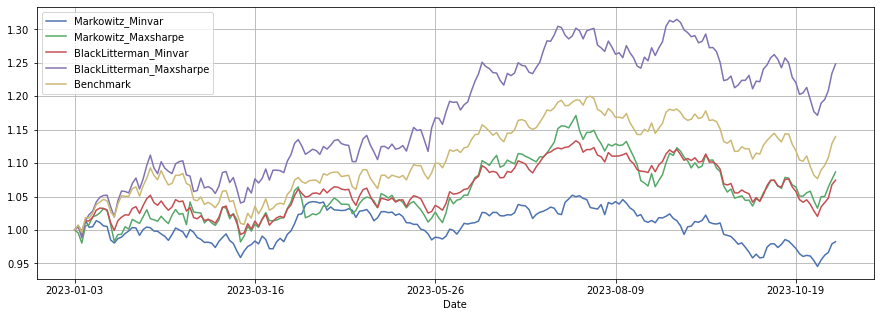

In [42]:
# Data para testing
test = pd.read_csv('test_prices.csv').set_index('Date')
benchmark = pd.read_csv('test_market.csv').set_index('Date')

# OrderedDict to array
weights_markowtiz_minvar = np.array([value for key, value in markowtiz.min_volatility().items()])
weights_markowitz_maxsharpe = np.array([value for key, value in markowtiz.max_sharpe().items()])
weights_bl_minvar = np.array([value for key, value in bl_minvar_weights.items()])
weights_bl_maxsharpe = np.array([value for key, value in bl_maxsharpe_weights.items()])

# Backtest
backtest= pd.DataFrame(index=test.index)
backtest['Markowitz_Minvar'] = [weights_markowtiz_minvar.dot(test.values[i]) for i in range(len(test))]
backtest['Markowitz_Maxsharpe'] = [weights_markowitz_maxsharpe.dot(test.values[i]) for i in range(len(test))]
backtest['BlackLitterman_Minvar'] = [weights_bl_minvar.dot(test.values[i]) for i in range(len(test))]
backtest['BlackLitterman_Maxsharpe'] = [weights_bl_maxsharpe.dot(test.values[i]) for i in range(len(test))]
backtest['Benchmark'] = benchmark

# Normalización
norm_backtest = backtest / backtest.iloc[0]

#Ploteo
norm_backtest.plot(figsize=(15,5))
plt.grid()

Comparativa Riesgo y Rendimiento

In [54]:
# Rendimiento del portafolio
(norm_backtest.iloc[-1] / norm_backtest.iloc[0]) - 1

Markowitz_Minvar           -0.017506
Markowitz_Maxsharpe         0.086674
BlackLitterman_Minvar       0.074444
BlackLitterman_Maxsharpe    0.248238
Benchmark                   0.139692
dtype: float64

In [56]:
# Volatilididad
norm_backtest.std()

Markowitz_Minvar            0.024019
Markowitz_Maxsharpe         0.043667
BlackLitterman_Minvar       0.035428
BlackLitterman_Maxsharpe    0.087355
Benchmark                   0.052069
dtype: float64

In [57]:
# Rendimeinto / Riesgo
((norm_backtest.iloc[-1] / norm_backtest.iloc[0]) - 1) / norm_backtest.std()

Markowitz_Minvar           -0.728830
Markowitz_Maxsharpe         1.984898
BlackLitterman_Minvar       2.101295
BlackLitterman_Maxsharpe    2.841713
Benchmark                   2.682801
dtype: float64

# Referencias

* Markowitz, H. (1952). Portfolio Selection. The Journal of Finance, 7(1), 77-91.
* Fischer Black, Robert Litterman. "Global Portfolio Optimization." Financial Analysts Journal, 1992.
* O. Ledoit, M. Wolf. "Honey, I Shrunk the Sample Covariance Matrix." The Journal of Portfolio Management, 2004.
* L. A. Pastur, M. Shcherbina. "Eigenvalue distribution of large random matrices." Mathematical Surveys and Monographs, 2011.